# Mask R-CNN Training and Inference
In this notebook we use Matterport's implementation of Mask R-CNN to train on a custom dataset, then use the trained weights to run inference on new images.

This is part of a tutorial posted at http://www.immersivelimit.com/tutorials/using-mask-r-cnn-on-custom-coco-like-dataset, so check there for more details.

### Not a beginner tutorial...
This is not intended to be a complete beginner tutorial.
- You should know how to clone a git repository from GitHub
- You should have a decent understanding of Python programming
- You should understand the basics of training deep neural networks. If you've never done it before, I wouldn't recommend starting here. Find a beginner deep learning tutorial/course and start there. There's lots of great free stuff on YouTube.

## **Download the Free Training Dataset First!
I've provided a free training dataset of cigarette butt images for use with this tutorial.
1. Download it from here: http://www.immersivelimit.com/datasets/cigarette-butts
2. Then extract the files and put it in the "../datasets" directory of this repo
3. The code below will be looking for "../datasets/cig_butts/train", "../datasets/cig_butts/val", and "../datasets/cig_butts/real_test"

In [1]:
import os
import sys
import json
import numpy as np
import time
import datetime
import skimage.draw
from PIL import Image, ImageDraw

from imgaug import augmenters as iaa

## Import Matterport's "mrcnn" libraries
1. I'm using a forked version of Matterport's Mask_RCNN git repo to make sure this code works, even if the main repo changes. As of July 29, 2018, there is a bug in Matterport's version that breaks loading an existing model that I've fixed in my version (and submitted a pull request to fix it in theirs).
  - My version is here: https://github.com/akTwelve/Mask_RCNN
  - The original is here: https://github.com/matterport/Mask_RCNN
2. Update the code cell below to point to the root directory of the repo on your machine.

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '../Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib


## Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, updated it here.

It will also download the pre-trained coco model.

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


## Configuration
Define configurations for training on the Cigarette Butt dataset.
### Note
These are settings that worked on my machine (GTX 970 graphics card). If you are getting OOM (Out of Memory) errors, you may need to tweak the settings or your computer may not be powerful enough. If you have a better graphics card, you will want to tweak it to take advantage of that.

In [4]:
class OrangeCanopyConfig(Config):
    """Configuration for training on the orange's tree canopy dataset.
    Derives from the base Config class and overrides values specific
    to the orange's tree canopy dataset.
    """
    # Give the configuration a recognizable name
    NAME = "oranges_trees_canopy"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (trees canopy)

    # All of our training images are 512x512
    # IMAGE_MIN_DIM = 256       # Configurado abaixo
    # IMAGE_MAX_DIM = 256       # Configurado abaixo

    # You can experiment with this number to see if it improves training
    # Antes: 500
    STEPS_PER_EPOCH = 4171  # Valor baseado em gaciaBraga (trees.py)

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    # Antes: 5
    VALIDATION_STEPS = 1001  # Valor baseado em gaciaBraga (trees.py)

    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'  # garciaBraga (trees.py) tbm usa resnet50

    # To be honest, I haven't taken the time to figure out what these do
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)      # Configurado abaixo
    # TRAIN_ROIS_PER_IMAGE = 32     # Configurado abaixo
    # MAX_GT_INSTANCES = 50     # Configurado abaixo
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000

    # CigButts configura apenas os parâmetros acima. A partir desse ponto, são configurações beseadas em garciaBraga (trees.py)

    DETECTION_MIN_CONFIDENCE = 0.5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)
    USE_MINI_MASK = False
    IMAGE_CHANNEL_COUNT = 3
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9
    # I left this equal to 220, but during the training my images had a maximum of 150 tree crowns (garciaBraga -> trees.py)
    # I left this equal to 100
    MAX_GT_INSTANCES = 100
    DETECTION_MAX_INSTANCES = 100
    TRAIN_ROIS_PER_IMAGE = 100
    RPN_TRAIN_ANCHORS_PER_IMAGE = 100
    #
    RPN_NMS_THRESHOLD = 0.9
    MEAN_PIXEL = np.array([105, 236, 189])
    DETECTION_NMS_THRESHOLD = 0.3
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.,
        "rpn_bbox_loss": 1.,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.,
        "mrcnn_mask_loss": 1.
    }
    
config = OrangeCanopyConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

# Define the dataset
I've attempted to make this generic to any COCO-like dataset. That means if you have another dataset defined in the COCO format, it should work.

In [5]:
greeningclass OrangeCanopyDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """

    def load_data(self, dataset_dir, subset):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """

        assert subset in ['train', 'val', 'prediction']
        dataset_dir = os.path.join(dataset_dir, subset)

        annotation_json = os.path.join(dataset_dir, 'coco_annotations.json')
        images_dir = os.path.join(dataset_dir, 'images')

        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()

        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(
                    class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    # End load_data

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids
    # end load_mask

# Create the Training and Validation Datasets
Make sure you download the training dataset linked at the top of this notebook. If you put the dataset somewhere else, update the paths below.

In [6]:
train_dataset = OrangeCanopyDataset()
train_dataset.load_data('../Mask_RCNN/datasets/canopy', 'train')
train_dataset.prepare()

val_dataset = OrangeCanopyDataset()
val_dataset.load_data('../Mask_RCNN/datasets/canopy', 'val')
val_dataset.prepare()

augmentation = iaa.SomeOf((0, 2), [iaa.Fliplr(0.5), iaa.Flipud(0.5), iaa.OneOf(
    [iaa.Affine(rotate=90), iaa.Affine(rotate=180), iaa.Affine(rotate=270)]), iaa.Multiply((0.5, 1.5))])

## Display a few images from the training dataset

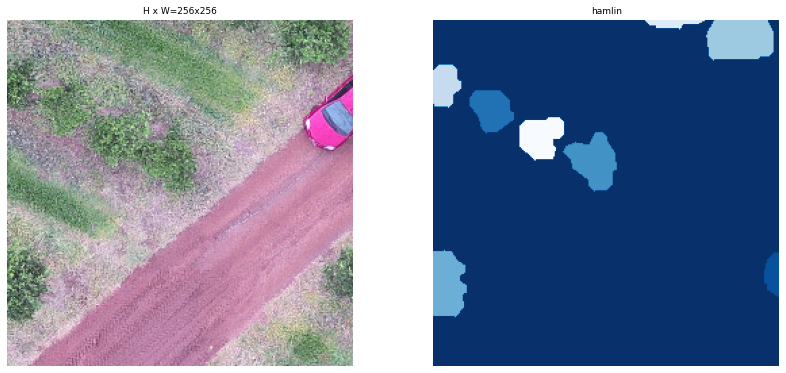

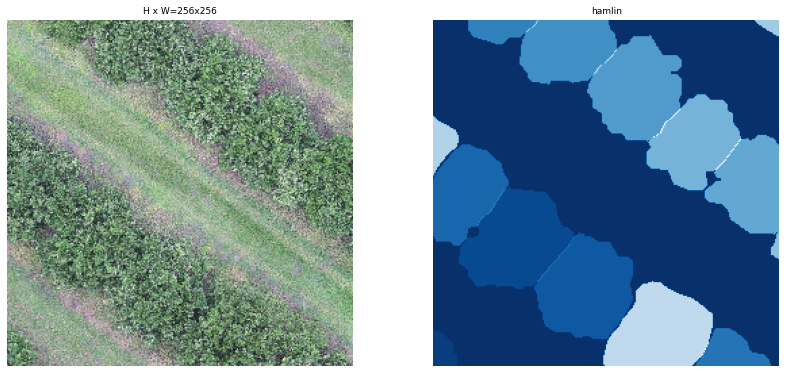

In [7]:
dataset = train_dataset
image_ids = np.random.choice(dataset.image_ids, 2)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

# Create the Training Model and Train
This code is largely borrowed from the train_shapes.ipynb notebook.

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True, 
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
                      )
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers='all' to train all layers.



In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()

model.train(train_dataset, 
            val_dataset, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            augmentation=augmentation,
            layers='heads')

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)

print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ../Mask_RCNN/logs/oranges_trees_canopy20210722T1521/mask_rcnn_oranges_trees_canopy_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mr

/home/user/anaconda3/envs/rcnn/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/user/anaconda3/envs/rcnn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-e6d4ac887636>", line 12, in <module>
    layers='heads')
  File "/home/user/anaconda3/envs/rcnn/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg/mrcnn/model.py", line 2367, in train
    use_multiprocessing=workers > 1,
  File "/home/user/anaconda3/envs/rcnn/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_v1.py", line 814, in fit
    use_multiprocessing=use_multiprocessing)
  File "/home/user/anaconda3/envs/rcnn/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_generator_v1.py", line 590, in fit
    steps_name='steps_per_epoch')
  File "/home/user/anaconda3/envs/rcnn/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_generator_v1.py", line 216, in model_iteration
    batch_data = _get_next_batc

TypeError: object of type 'NoneType' has no len()

# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [ ]:
class InferenceConfig(CigButtsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [ ]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [ ]:
# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR,'logs','canopy20210715T1633', "mask_rcnn_canopy_0005.h5")
# model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# Run Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

In [ ]:
import skimage
real_test_dir = '../Mask_RCNN/datasets/canopy/real_test/images'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))
    

In [ ]:
image_path

In [ ]:
dataset_val.class_names